In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.mps import mps
from src.mps import tebd
from src.tdvp import tdvp
from src.mps import tfi_model
from src.mps import mps_runge_kutta

In this notebook we will compare the time evolution of the two-site Time Dependent Variational Principle (TDVP) method with standard Time Evolving Block Decimation (TEBD), using the transverse field ising model (TFI) as an example.

In [3]:
def overlap(bra, ket):
    L = len(bra.Bs)
    assert(L == len(ket.Bs))
    left = np.ones(1)
    left = np.reshape(left, (1, 1))
    for n in range(L):
        # Contract left with bra
        left = np.tensordot(left, bra.Bs[n].conj(), (0, 0))
        # Contract left with ket
        left = np.tensordot(left, ket.Bs[n], [(0, 1), (0, 1)])
    return left[0, 0]

# TEBD

In [52]:
L = 14

In [53]:
MPS_all_spin_up = mps.MPS.initialize_spinup(L)

In [54]:
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])

In [55]:
J = 1.
g = 1.5
chi_max = 10
eps = 1.e-10
dts_TEBD = [0.1, 0.01]
t_stop = 10*J

In [58]:
ms_TEBD = [[] for i in range(len(dts_TEBD))]
entropies_TEBD = [[] for i in range(len(dts_TEBD))]

model = tfi_model.TFIModel(L, J, g)

for i, dt in enumerate(dts_TEBD):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    U_bonds = tebd.calc_U_bonds(model, dt*1.j) # imagingary t for real time evolution!
    psi = MPS_all_spin_up.copy()
    for _ in range(N):
        tebd.run_TEBD(psi, U_bonds, N_steps=1, chi_max=chi_max, eps=eps)
        ms_TEBD[i].append(np.sum(psi.site_expectation_value(sigma_z)))
        entropies_TEBD[i].append(psi.entanglement_entropy()[L//2])
    end = time.time()
    print("took", end-start, "seconds!")

computing for dt = 0.1
took 0.3779594898223877 seconds!
computing for dt = 0.01
took 3.3162643909454346 seconds!


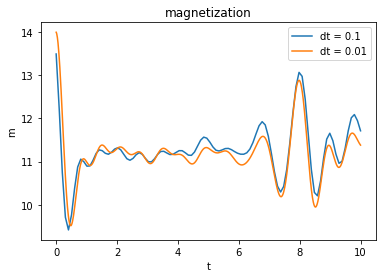

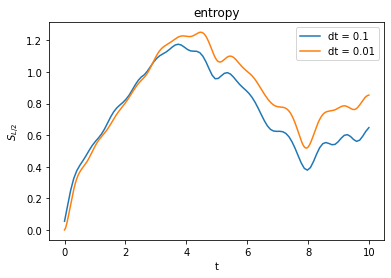

In [59]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], label="dt = "+str(dt))
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_TEBD[i], label="dt = "+str(dt))
plt.legend()
plt.title("entropy")
plt.ylabel("$S_{L/2}$")
plt.xlabel("t")
plt.show()

# TDVP

In [61]:
dts_TDVP = [0.1, 0.01]

ms_TDVP = [[] for i in range(len(dts_TDVP))]
entropies_TDVP = [[] for i in range(len(dts_TDVP))]

model = tfi_model.TFIModel(L, J, g)

chi_max = 10
eps = 1.e-10

for i, dt in enumerate(dts_TDVP):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = MPS_all_spin_up.copy()
    engine = tdvp.TDVPEngine(psi, model, dt, chi_max=chi_max, eps=eps)
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP[i].append(np.sum(engine.psi.site_expectation_value(sigma_z)))
        entropies_TDVP[i].append(engine.psi.entanglement_entropy()[L//2])
    end = time.time()
    print("took", end-start, "seconds")

computing for dt = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

took 21.536417245864868 seconds
computing for dt = 0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

took 187.12743663787842 seconds


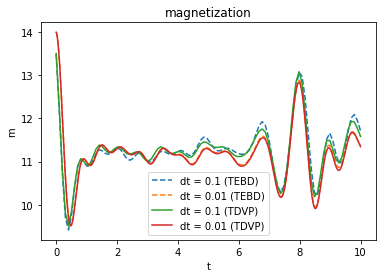

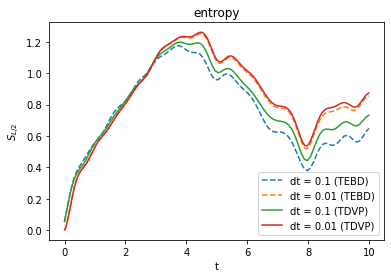

In [62]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP[i], label="dt = "+str(dt)+" (TDVP)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_TDVP[i], label="dt = "+str(dt)+" (TDVP)")
plt.legend()
plt.title("entropy")
plt.ylabel("$S_{L/2}$")
plt.xlabel("t")
plt.show()

TDVP achieves roughly the same results as TEBD, but is roughly 20 times slower.
The advantage of course is that TDVP works with MPOS and can therefore also describe long-range interactions in contrast to TEBD which can only describe nearest-neighbour interactions.

# Runge-Kutta

In [64]:
dts_RK4 = [0.1, 0.01]

ms_RK4 = [[] for i in range(len(dts_RK4))]
entropies_RK4 = [[] for i in range(len(dts_RK4))]

model = tfi_model.TFIModel(L, J, g)

chi_max = 10
eps = 1.e-10

for i, dt in enumerate(dts_RK4):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = MPS_all_spin_up.copy()
    update_mpo = [W.copy() for W in model.H_mpo]
    update_mpo[0] = -1.j * update_mpo[0]
    for _ in tqdm(range(N)):
        psi = mps_runge_kutta.integrate_MPS_RK4(psi, dt, update_mpo, chi_max, eps)
        ms_RK4[i].append(np.sum(psi.site_expectation_value(sigma_z)))
        entropies_RK4[i].append(psi.entanglement_entropy()[L//2])
    end = time.time()
    print("took", end-start, "seconds")

computing for dt = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

took 4.784730672836304 seconds
computing for dt = 0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

took 41.375152826309204 seconds


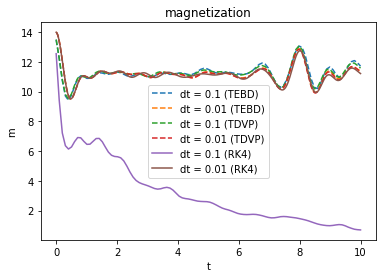

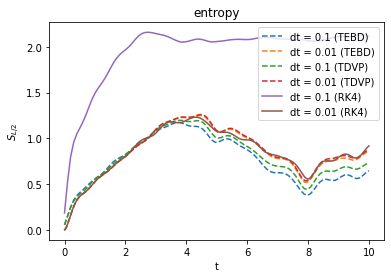

In [65]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP[i], "--", label="dt = "+str(dt)+" (TDVP)")
for i, dt in enumerate(dts_RK4):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_RK4[i], label="dt = "+str(dt)+" (RK4)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_TDVP[i], "--", label="dt = "+str(dt)+" (TDVP)")
for i, dt in enumerate(dts_RK4):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, entropies_RK4[i], label="dt = "+str(dt)+" (RK4)")
plt.legend()
plt.title("entropy")
plt.ylabel("$S_{L/2}$")
plt.xlabel("t")
plt.show()